# Cleaning Data at Scale

By Dr. Phil Winder of https://WinderResearch.com

Hi there! Welcome to this notebook which was originally written to be used with the training of the same name. If you like this then please visit my website for more, [tweet @DrPhilWinder](https://twitter.com/DrPhilWinder) or get in touch via [Linkedin](https://www.linkedin.com/in/DrPhilWinder/) or plain old [email](mailto:phil@WinderResearch.com).

Table of Contents:

1. [Visualising Data](#1.-Visualising-Data)
2. [Fixing Missing Data](#2.-Fixing-Missing-Data)
3. [Detect and Remove Outliers](#3.-Detect-and-Remove-Outliers)
4. [Is it Normal?](#4.-Is-it-Normal?)
5. [Fixing Non-Normal Data](#5.-Fixing-Non-Normal-Data)
6. [Fixing Scales and Categorical Data](#6:-Fixing-Scales-and-Categorical-Data)
7. [Model Improvement through Feature Selection](#7:-Model-Improvement-through-Feature-Selection)
8. [Cleaning Timeseries Data](#8:-Cleaning-Timeseries-Data)

In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns

In [2]:
sns.set(style="white")
matplotlib.rc('figure', figsize=[12, 5])

# 1. Visualising Data

This first section is all about visualising your data. In my opinion, manually visualising data is the most important Data Science technique, but also the most underrepresented.

Below I concentrate on demonstrating some techniques that will help you pre-process and clean your data.

In [3]:
!pip install missingno > /dev/null
import pandas as pd
import missingno as msno
import numpy as np

In [4]:
url = "http://free.trainingdatascience.com.s3.amazonaws.com/data/titanic.csv"
titanic = pd.read_csv(url)

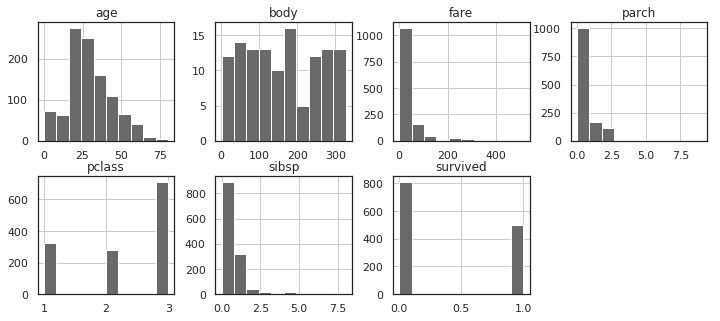

In [5]:
titanic.hist(color='dimgray', layout=(2, 4));

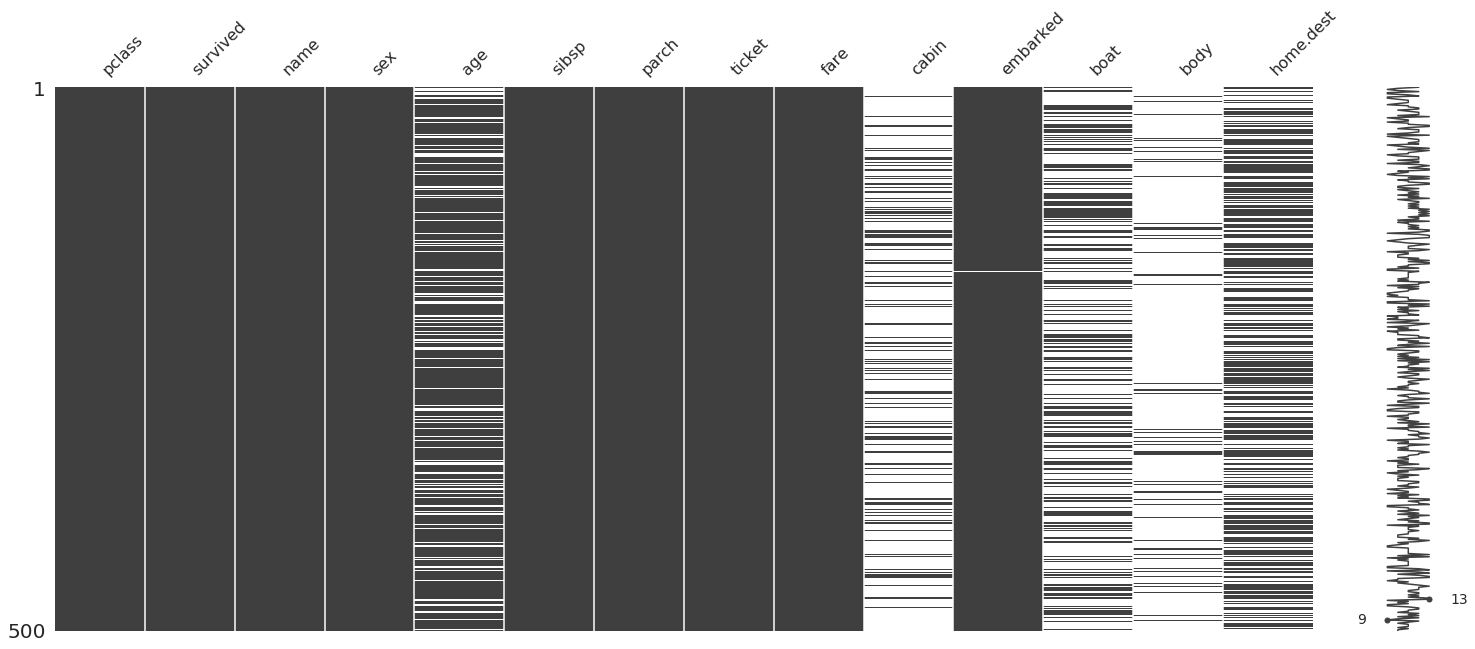

In [6]:
msno.matrix(titanic.sample(500));

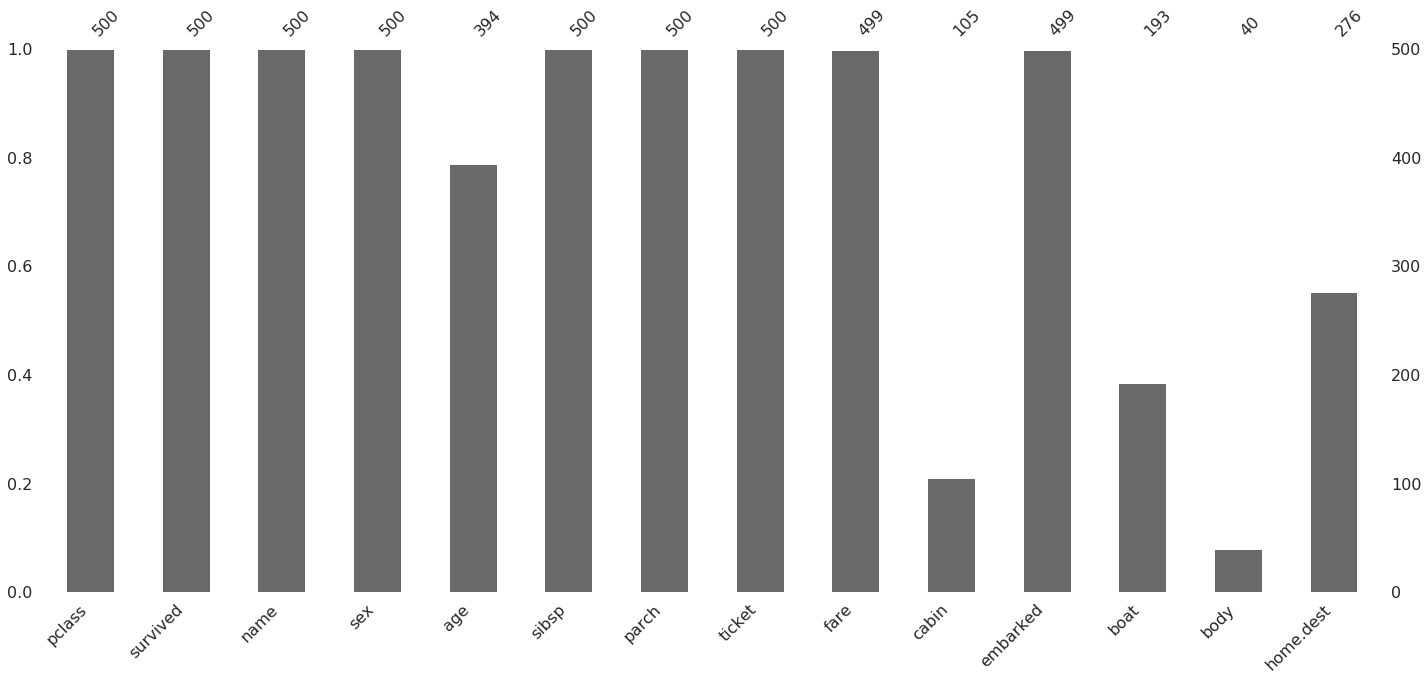

In [7]:
msno.bar(titanic.sample(500));

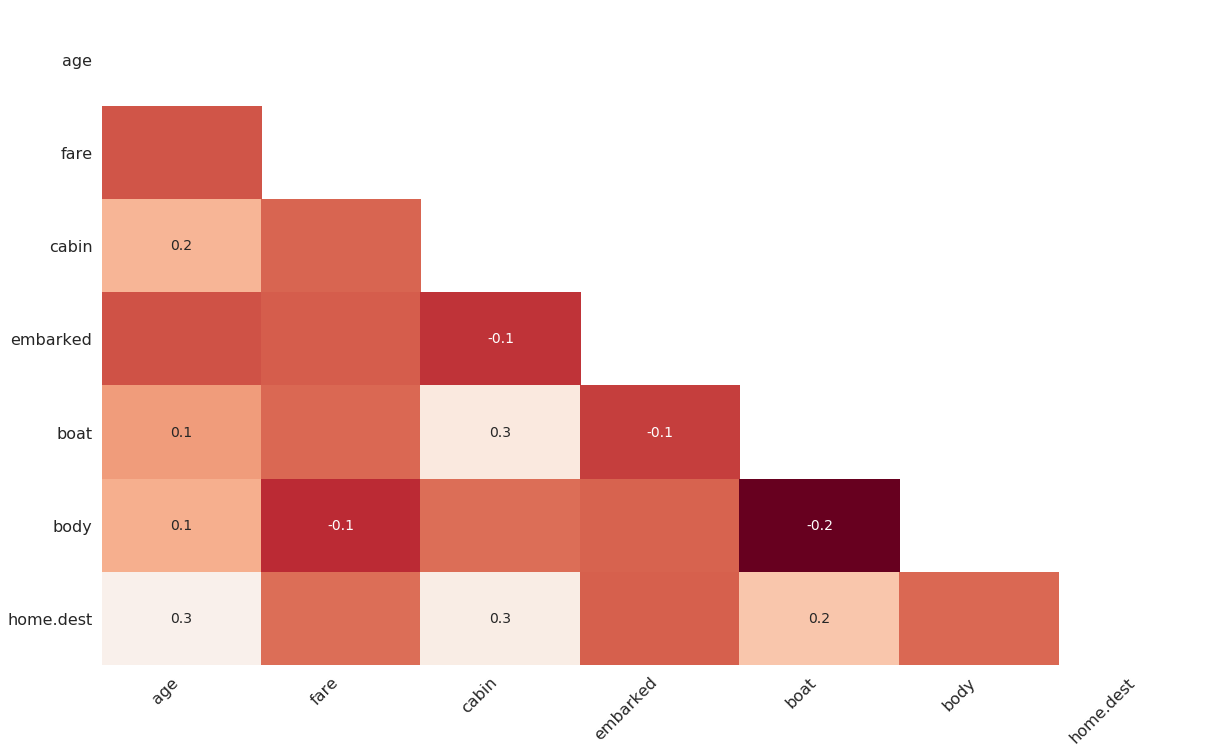

In [8]:
msno.heatmap(titanic);

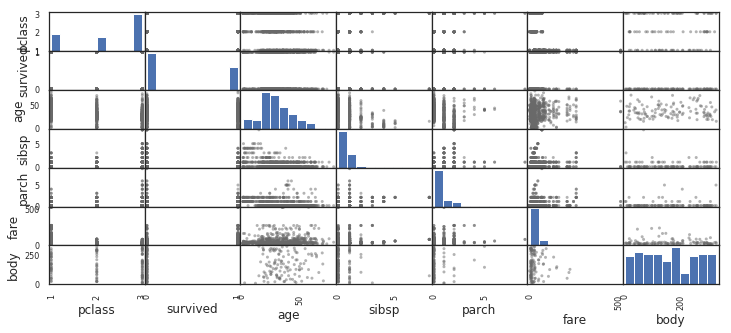

In [9]:
pd.plotting.scatter_matrix(titanic, color='dimgray');

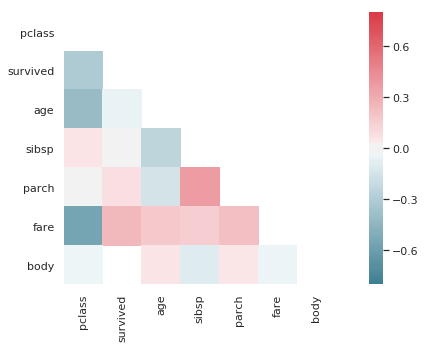

In [10]:
# Compute the correlation matrix
corr = titanic.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.8, vmin=-0.8, square=True);

In [11]:
url = "http://free.trainingdatascience.com.s3.amazonaws.com/data/nypd-motor-vehicle-collisions.csv"
collisions = pd.read_csv(url)

---
## Challenge

Above is the NYPD collisions dataset that reports the causes of traffic incidents in New York (not to be confused with York) in the USA.

- Try plotting some visualisations of this data
- What can you tell me about it?

---

# 2. Fixing Missing Data

Most real world datasets have missing values. Many examples online and in the literature present data that has already been cleaned. But in industry, significant amounts of data are missing. Let's get some experience working with that.

In [12]:
import pandas as pd
import sklearn.linear_model

In [13]:
url = "http://free.trainingdatascience.com.s3.amazonaws.com/data/titanic.csv"
titanic = pd.read_csv(url)

In [14]:
titanic = titanic[['survived', 'fare', 'age']]
titanic.count()

survived    1309
fare        1308
age         1046
dtype: int64

Pandas has a very handy function called `dropna()` that removes all rows that have at least one `NaN`.

In [15]:
titanic.dropna().count()

survived    1045
fare        1045
age         1045
dtype: int64

We can also replace missing values with another value. Zero, for example:

In [16]:
titanic.fillna(0).describe()

,survived,fare,age
count,1309.000000,1309.000000,1309.000000
mean,0.381971,33.270043,23.877517
std,0.486055,51.747063,17.590845
min,0.000000,0.000000,0.000000
25%,0.000000,7.895800,7.000000
50%,0.000000,14.454200,24.000000
75%,1.000000,31.275000,35.000000
max,1.000000,512.329200,80.000000


Or with some function of the columns, like the mean or the median:

In [17]:
titanic.fillna(titanic.mean()).describe()

,survived,fare,age
count,1309.000000,1309.000000,1309.000000
mean,0.381971,33.295479,29.881138
std,0.486055,51.738879,12.883193
min,0.000000,0.000000,0.170000
25%,0.000000,7.895800,22.000000
50%,0.000000,14.454200,29.881138
75%,1.000000,31.275000,35.000000
max,1.000000,512.329200,80.000000


Note how the `age` feature changes quite dramatically depending on what you impute it with. You will probably want to plot the histogram of this in real life to make sure you're not trashing the statistics.

We could go further and even create a regression model to predict the ages...

In [18]:
titanic_dropped = titanic.dropna()
X = titanic_dropped[['survived', 'fare']]
y = titanic_dropped['age']
mdl = sklearn.linear_model.LinearRegression().fit(X, y)

In [19]:
titanic_X = titanic.dropna(subset = ['survived', 'fare']) # Inputs to an sklearn model can't have NaNs
print(titanic_X.count())
titanic_imputed = titanic_X.copy()
titanic_imputed['age_imputed'] = mdl.predict(titanic_X[['survived', 'fare']])
print(titanic_imputed.tail(10))
print(titanic_imputed.count())
titanic_fixed = titanic_X.copy()
titanic_fixed['age'] = titanic_fixed['age'].fillna(titanic_imputed['age_imputed'])
print(titanic_fixed.tail(10))
print(titanic_fixed.count())

survived    1308
fare        1308
age         1045
dtype: int64
      survived     fare   age  age_imputed
1299         0  14.4542  27.0    29.931119
1300         1  14.4542  15.0    26.858733
1301         0   7.2250  45.5    29.548673
1302         0   7.2250   NaN    29.548673
1303         0  14.4583   NaN    29.931336
1304         0  14.4542  14.5    29.931119
1305         0  14.4542   NaN    29.931119
1306         0   7.2250  26.5    29.548673
1307         0   7.2250  27.0    29.548673
1308         0   7.8750  29.0    29.583060
survived       1308
fare           1308
age            1045
age_imputed    1308
dtype: int64
      survived     fare        age
1299         0  14.4542  27.000000
1300         1  14.4542  15.000000
1301         0   7.2250  45.500000
1302         0   7.2250  29.548673
1303         0  14.4583  29.931336
1304         0  14.4542  14.500000
1305         0  14.4542  29.931119
1306         0   7.2250  26.500000
1307         0   7.2250  27.000000
1308         0   7.8

Beware, every time we impute the data we're adding subtle biases. For example, if we imputed one feature that was mostly `NaN`s the effect would be that this feature correlates with other features that produced it. If we were performing a classification task, this would be pointless.

In [20]:
url = "http://free.trainingdatascience.com.s3.amazonaws.com/data/titanic.csv"
titanic = pd.read_csv(url)
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [21]:
url = "https://raw.githubusercontent.com/dataoptimal/posts/master/data%20cleaning%20with%20python%20and%20pandas/property%20data.csv"
housing = pd.read_csv(url)
housing = housing[['NUM_BATH', 'SQ_FT', 'OWN_OCCUPIED']]
housing = housing.replace(['--', 'HURLEY', 'na', '12'], np.nan)
housing = housing.replace(['Y'], 1)
housing = housing.replace(['N'], 0)
housing

,NUM_BATH,SQ_FT,OWN_OCCUPIED
0,1,1000,1.0
1,1.5,NaN,0.0
2,1,850,0.0
3,NaN,700,NaN
4,2,1600,1.0
5,1,800,1.0
6,NaN,950,NaN
7,1,NaN,1.0
8,2,1800,1.0


---
## Challenge

There is a very simple hacky dataset above.

1. Try dropping `NaN` rows?
2. What about replacing with zeros?
3. Try to impute using a regression model

---

# 3. Detect and Remove Outliers

Outliers are tricky because we often don't have any ground truth to prove that outliers truly are outliers. So largely this is part art.

Here's an example.

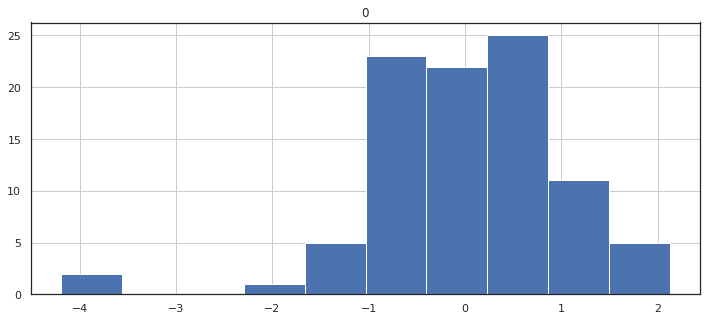

In [22]:
arr = pd.DataFrame([10, 386, 479, 627, 20, 523, 482, 483, 542, 699, 535, 617, 577, 471, 615, 583, 441, 562, 563, 527, 453, 530, 433, 541, 585, 704, 443, 569, 430, 637, 331, 511, 552, 496, 484, 566, 554, 472, 335, 440, 579, 341, 545, 615, 548, 604, 439, 556, 442, 461, 624, 611, 444, 578, 405, 487, 490, 496, 398, 512, 422, 455, 449, 432, 607, 679, 434, 597, 639, 565, 415, 486, 668, 414, 665, 763, 557, 304, 404, 454, 689, 610, 483, 441, 657, 590, 492, 476, 437, 483, 529, 363, 711, 543])
arr = (arr - arr.mean()) / arr.std()
arr.hist();

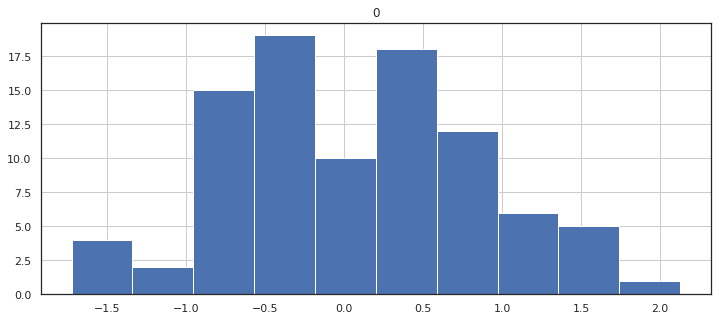

In [23]:
arr = arr[np.abs(arr) < 3]
arr.hist();

In [24]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine = pd.read_csv(url)
wine = pd.read_csv(url, sep=";")
wine = wine[['alcohol', 'quality']]
wine.head(n=5)

,alcohol,quality
0,9.4,5
1,9.8,5
2,9.8,5
3,9.8,6
4,9.4,5


---
## Challenge

Above is a more realistic wine dataset. Can you remove the outliers?

---

# 4. Is it Normal?

Normality is important for a range of algorithms. Here we investigate, what is normal? 

In [25]:
import statsmodels.api as sm
import scipy
import matplotlib.pyplot as plt

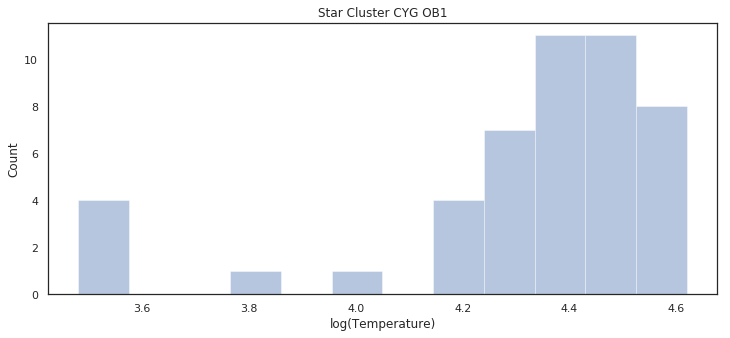

In [26]:
starsCYG = sm.datasets.get_rdataset("starsCYG", "robustbase", cache=True).data
var = 'log.Te'

ax = sns.distplot(starsCYG[var], kde=False, norm_hist=False)
ax.set(title='Star Cluster CYG OB1', xlabel='log(Temperature)', ylabel='Count');

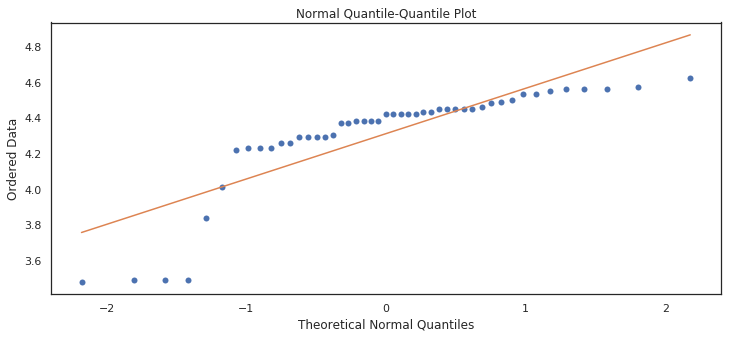

In [27]:
scipy.stats.probplot(
    starsCYG[var], plot=sns.mpl.pyplot)
ax = plt.gca()
ax.get_lines()[0].set_markerfacecolor(sns.color_palette()[0])
ax.get_lines()[0].set_markeredgewidth(0)
ax.get_lines()[1].set_color(sns.color_palette()[1])
ax.set(title='Normal Quantile-Quantile Plot',
       xlabel='Theoretical Normal Quantiles', ylabel='Ordered Data');

/opt/conda/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:437: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


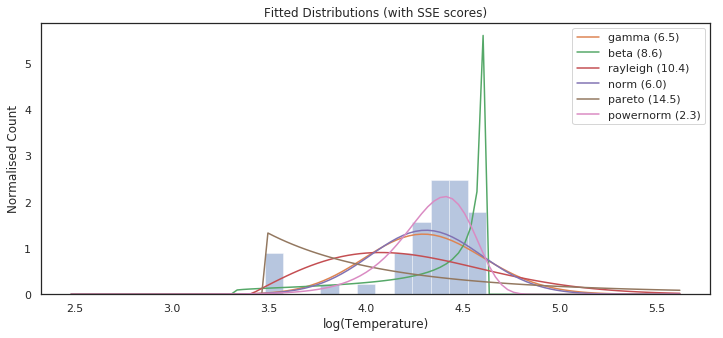

In [28]:
# Distribution fitting

y = starsCYG[var]
x_plot = scipy.linspace(min(y) - 1, max(y) + 1, 100)
y_count, x = np.histogram(y, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
h = sns.distplot(y, kde=False, norm_hist=True)

dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto', 'powernorm']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    params = dist.fit(y)
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    pdf_fitted = dist.pdf(x, loc=loc, scale=scale, *arg)
    sse = np.sum(np.power(y_count - pdf_fitted, 2.0))
    pdf_plot = dist.pdf(x_plot, loc=loc, scale=scale, *arg)
    sns.lineplot(x_plot, pdf_plot, label='{} ({:.1f})'.format(dist_name, sse))
plt.legend(loc='upper right')
ax = plt.gca()
ax.set(title='Fitted Distributions (with SSE scores)',
       xlabel='log(Temperature)', ylabel='Normalised Count');

In [29]:
data = pd.DataFrame(2 * np.random.randn(200) + 20)

---
## Challenge

Using the data `data`, is it normally distributed?

---

# 5. Fixing Non-Normal Data

Once you know that you have some data that is not normal, you can attempt to bring it back to normality.

In [30]:
url = "http://free.trainingdatascience.com.s3.amazonaws.com/data/titanic.csv"
titanic = pd.read_csv(url)
fare = titanic['fare']

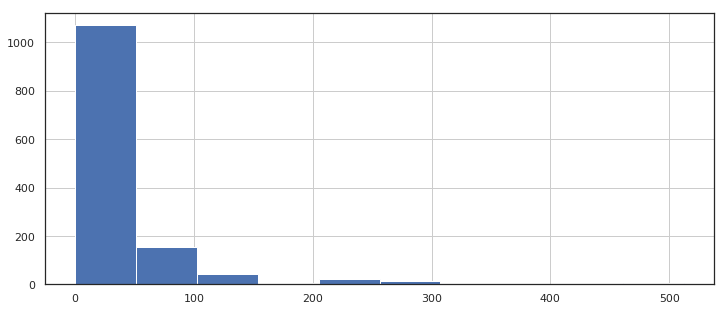

In [31]:
fare.hist();

---
## Challenge

Try applying a few mathematical functions to invert this data. Have a go using `np.log`, `np.power`, `np.sqrt`.

---

# 6: Fixing Scales and Categorical Data

Fixing the scales of data is important to make it as easy as possible for the model. This is a classification example - where I limit the number of training iterations to make the point - that breaks because the scales are so skewed. After min-max scaling the data, the model finds it much easier to iterate towards the result.

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sel

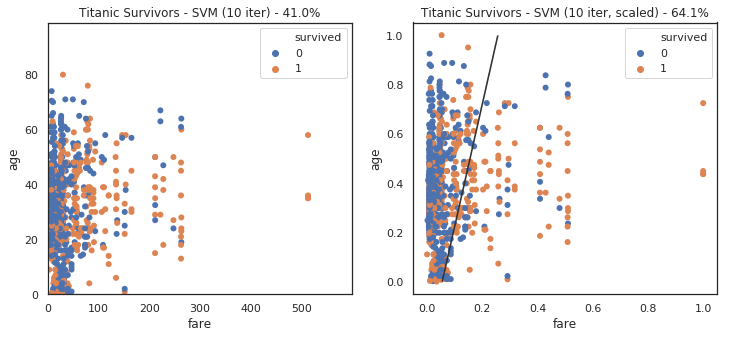

In [32]:
np.random.seed(42)
url = "http://free.trainingdatascience.com.s3.amazonaws.com/data/titanic.csv"
titanic = pd.read_csv(url)
titanic = titanic[['survived', 'fare', 'age']]
titanic.dropna(inplace=True)
titanic = titanic[(titanic[['fare', 'age']] != 0).all(axis=1)]  # Remove zero fares
y = titanic['survived']
X = titanic[['fare', 'age']]

clf = sklearn.svm.LinearSVC(tol=1e-2, max_iter=10).fit(X, y)
xx, yy = np.mgrid[0:600:1, 0:100:1]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict(grid).reshape(xx.shape)
score = clf.score(X, y) * 100

fig, (ax1, ax2) = plt.subplots(ncols=2)

sns.scatterplot(data=X, x='fare', y='age', hue=y, linewidth=0, ax=ax1).set_title(
    "Titanic Survivors - SVM (10 iter) - {:.1f}%".format(score))
ax1.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

X[:] = sklearn.preprocessing.MinMaxScaler().fit_transform(X[:])
clf = sklearn.svm.LinearSVC(tol=1e-2, max_iter=10).fit(X, y)
xx, yy = np.mgrid[0:1:0.001, 0:1:0.001]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict(grid).reshape(xx.shape)
score = clf.score(X, y) * 100

sns.scatterplot(data=X, x='fare', y='age', hue=y, linewidth=0, ax=ax2).set_title(
    "Titanic Survivors - SVM (10 iter, scaled) - {:.1f}%".format(score))
ax2.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6);

In [33]:
s = pd.Series(list('abcaba'))
pd.get_dummies(s)

,a,b,c
0,1,0,0
1,0,1,0
2,0,0,1
3,1,0,0
4,0,1,0
5,1,0,0


Above we're rencoding categorical variables into new features. Now we can pass this data into our standard models.

In [34]:
url = "http://free.trainingdatascience.com.s3.amazonaws.com/data/titanic.csv"
titanic = pd.read_csv(url)

In [35]:
X = titanic[['age', 'embarked', 'fare', 'survived']]
X = X.dropna()
y = X[['survived']]
X = X[['age', 'embarked', 'fare']]

---
## Challenge

Above we see the Titanic data again. 

- Try to recode the `embarked` feature
- Then use the features X to predict the label y in a classification model

---

# 7: Model Improvement through Feature Selection

The Decision Tree classifier (and variants of) attempts to segment the data into "pure" buckets via simple thresholds. The split that produces the most "pure" bucket is deemed to be a good split.

We can use this definition of "good" to provide some information about how well a single feature is able to split segment the data according to the labels. "Better" features will have a higher score.

The example below uses the titanic dataset again to demonstrate this.

In [36]:
import pandas as pd
import sklearn.tree
import numpy as np
import matplotlib.pyplot as plt

In [37]:
url = "http://free.trainingdatascience.com.s3.amazonaws.com/data/titanic.csv"
titanic = pd.read_csv(url)
X = titanic[['age', 'fare', 'survived']]
X = X.dropna()
y = X[['survived']]
X = X[['age', 'fare']]

In [38]:
mdl = sklearn.tree.DecisionTreeClassifier().fit(X, y)

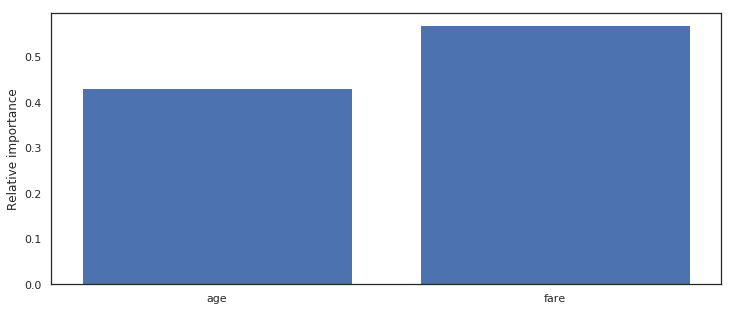

In [39]:
plt.bar(X.columns, mdl.feature_importances_)
plt.gca().set_ylabel('Relative importance');

We can see that the `fare` feature is more informative than the `age` parameter.

### Brute Force

Another thing we can do is iterate over features to find the best combination. Let's use `mlxtend` to implement this for us (and borrow an example)

In [40]:
!pip install mlxtend > /dev/null

best combination (ACC: 0.992): (0, 1, 2, 3, 6, 8, 9, 10, 11, 12)



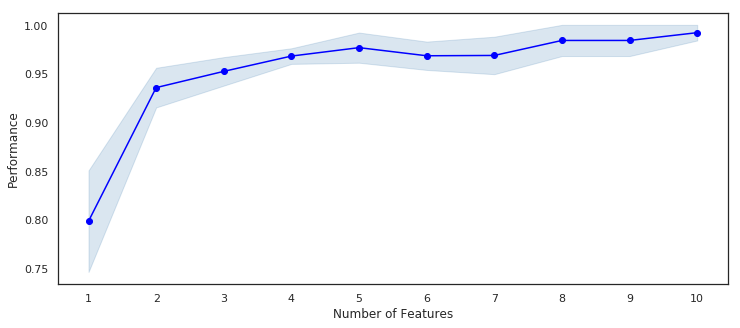

In [41]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.data import wine_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X, y = wine_data()
X_train, X_test, y_train, y_test= train_test_split(X, y, 
                                                   stratify=y,
                                                   test_size=0.3,
                                                   random_state=1)

knn = KNeighborsClassifier(n_neighbors=2)

sfs1 = SFS(estimator=knn, 
           k_features=(3, 10),
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=5)

pipe = make_pipeline(StandardScaler(), sfs1)

pipe.fit(X_train, y_train)

print('best combination (ACC: %.3f): %s\n' % (sfs1.k_score_, sfs1.k_feature_idx_))
# print('all subsets:\n', sfs1.subsets_)
plot_sfs(sfs1.get_metric_dict(), kind='std_err');

In [42]:
from sklearn.datasets import load_iris
from mlxtend.evaluate import PredefinedHoldoutSplit
import numpy as np


iris = load_iris()
X = iris.data
y = iris.target

---
## Challenge

Above is the infamous iris dataset.

- Can you tell me which feature is the most informative?

---

# 8: Cleaning Timeseries Data

Your domain might involve timeseries data. Much of what we have discussed also applies to the time domain. However there is a significant amount of knowledge that has been accumulated under the specialisation of Signal Processing.

But just to give you an idea, lets use the library `statsmodels` to give you some idea.

In [43]:
url = "http://free.trainingdatascience.com.s3.amazonaws.com/data/airline-passengers.csv"
airline = pd.read_csv(url)
airline.columns = ['month', 'passengers']
airline['month'] = pd.to_datetime(airline['month'])
airline.set_index('month', inplace=True)
airline.index = pd.DatetimeIndex(airline.index.values,freq=airline.index.inferred_freq)

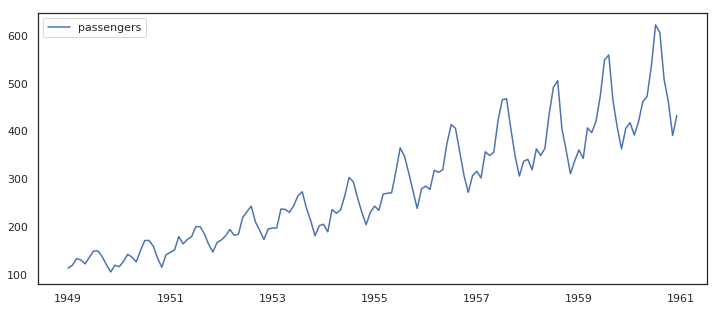

In [44]:
airline.plot();

First let me show you how to do some exponential smoothing. This is a simple averaging technique to perform "noise reduction". Note that we're not really reducing any noise, we're just saying that the rolling average of the data is a better representation of that data.

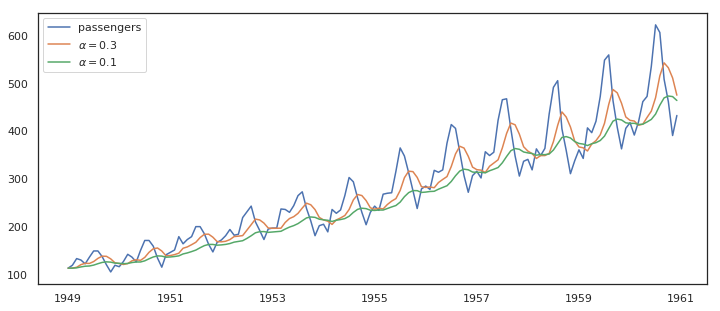

In [45]:
from statsmodels.tsa.api import SimpleExpSmoothing

airline.plot()

# Simple Exponential Smoothing
for alpha in [0.3, 0.1]:
    fit = SimpleExpSmoothing(airline).fit(smoothing_level=alpha,optimized=False)
    fit.fittedvalues.rename(r'$\alpha={}$'.format(alpha)).plot()
plt.legend();

Now let's remove a few samples to simulate some `NaN`s. Then we can perform some interpolation to fix it.

In [46]:
airline_corrupt = airline.copy()
airline_corrupt.iloc[10:11] = np.nan
airline_corrupt.iloc[30:35] = np.nan
airline_corrupt.iloc[60:100] = np.nan

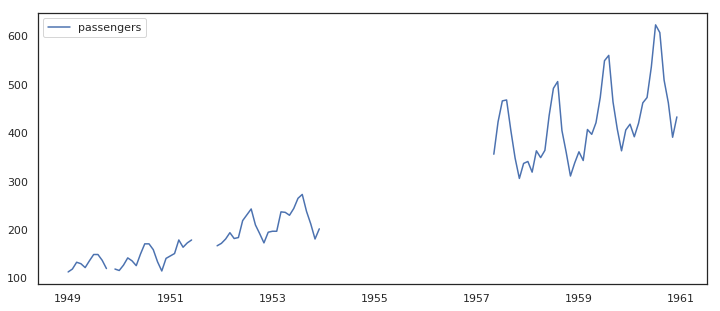

In [47]:
airline_corrupt.plot();

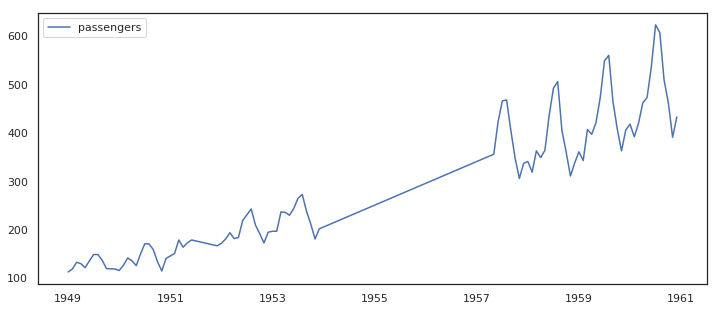

In [48]:
airline_corrupt.interpolate().plot();

Oneliner!

Note how pandas in using a linear implementation of interpolation. So we lose a lot of the seasonality in the data. 

Also note that the bigger the gap, the worse it seems to perform. We can barely see the single `NaN` around position 10.

Still very good for such little code though!

### Bonus: Seasonal decomposition

I thought I'd just add this as it's related. If you have seasonal data, `statsmodels` does a really nice job of decomposing the data to show you the periodicity and trend in the data. Take a look below:

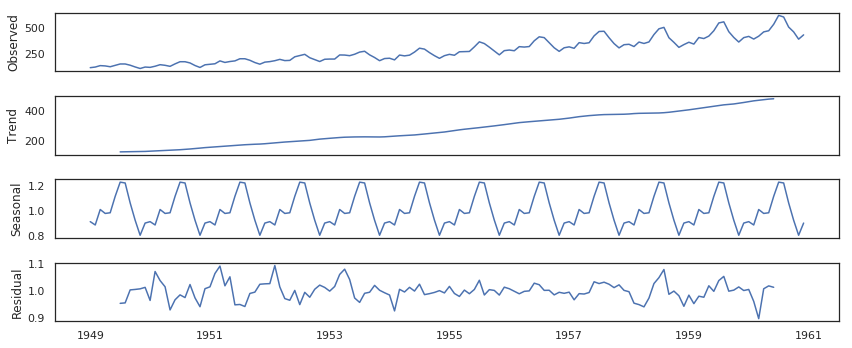

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(airline, model='multiplicative')
result.plot();

In [50]:
airline_outliers = airline.copy()
airline_outliers.iloc[10:11] = 0
airline_outliers.iloc[30:35] = 10000
airline_outliers.iloc[60:100] = 0

---
## Challenge

The dataset above contains outliers.

- Can you find the outliers?
- Can you remove the outliers and replace with an interpolation?

---